[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timz815/IAT360-CV-Project/blob/main/CVNotebook.ipynb)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path

In [ ]:
# =========
# Load Data
# =========

# For MAC
base_dir = "/Users/tim/Downloads/CV_dataset"

# For Windows
#base_dir = r"C:\Users\Tim\Downloads\CV_dataset"

ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


# Check if dataset is correct, can comment out
print(f"Dataset Folder found: {os.path.exists(base_dir)}")
print(f"Images found: {sum(len(glob.glob(os.path.join(img_dir, f'*.{ext}'))) for ext in ['png','jpg','jpeg'])}")
print(f"Annotations found: {len(glob.glob(os.path.join(ann_dir, '*.txt')))}")


Dataset Folder found: True
Images found: 5711
Annotations found: 5711


In [ ]:
# ==========
# Clean Data
# ==========

valid_pairs = []
image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
               glob.glob(os.path.join(img_dir, "*.jpg")) +
               glob.glob(os.path.join(img_dir, "*.jpeg")))

for image_file in image_files:
    image_filename = os.path.basename(image_file)
    label_file = os.path.join(ann_dir, image_filename + ".txt")

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            content = f.read().strip()

        if content:  # Simple check like fruit project
            valid_pairs.append((image_file, label_file))

print(f"Found {len(valid_pairs)} valid pairs")

Found 4474 valid pairs


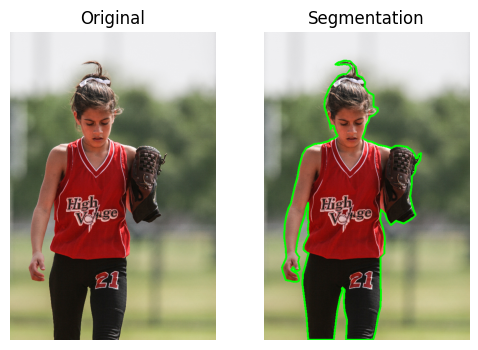

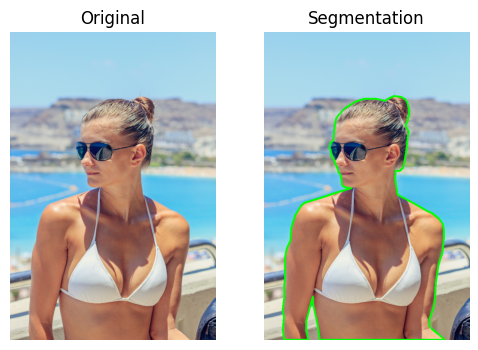

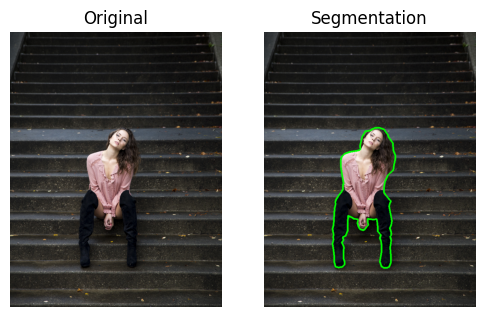

In [ ]:
# ===================
# Visualization Check
# ===================

for i in range(min(3, len(valid_pairs))):
    image_path, ann_path = valid_pairs[i]

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    overlay = image.copy()

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 6:
                # --- Bounding Box ---
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_w = float(parts[3]) * width
                box_h = float(parts[4]) * height

                x1 = int(x_center - box_w/2)
                y1 = int(y_center - box_h/2)
                x2 = int(x_center + box_w/2)
                y2 = int(y_center + box_h/2)

                # Red Box
                cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # --- Polygon Mask ---
                polygon_points = []
                for j in range(5, len(parts), 2):
                    if j + 1 < len(parts):
                        x = float(parts[j]) * width
                        y = float(parts[j + 1]) * height
                        polygon_points.append([x, y])

                if len(polygon_points) > 2:
                    pts = np.array(polygon_points, np.int32)
                    # Green Mask
                    cv2.polylines(overlay, [pts], True, (0, 255, 0), 3)

    # Display Config
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Segmentation")
    plt.axis('off')

    # Display
    plt.show()

In [ ]:
# ==================
# Create YAML Config
# ==================

yaml_path = os.path.join(base_dir, "segmentation_config.yaml")
yaml_content = f"""
path: {os.path.join(base_dir, "Final_Seg_Data")}
train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names:
  0: person
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

In [ ]:
# ===================
# Split and Copy Data
# ===================

base_output_dir = os.path.join(base_dir, "Final_Seg_Data")

train_images_dir = os.path.join(base_output_dir, "images/train")
if os.path.exists(train_images_dir) and len(os.listdir(train_images_dir)) > 0:
    print("Dataset already exists! Skipping file copying.")
    print(f"Found {len(os.listdir(train_images_dir))} images in train folder")
else:
    # Create new directories
    os.makedirs(os.path.join(base_output_dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/val"), exist_ok=True)

    # Split data for training and val
    split_idx = int(len(valid_pairs) * 0.8)
    train_pairs = valid_pairs[:split_idx]
    val_pairs = valid_pairs[split_idx:]

    print(f"Training samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")

    # Copy training data
    for image_path, ann_path in train_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/train", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/train", os.path.basename(ann_path)))

    # Copy validation data
    for image_path, ann_path in val_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/val", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/val", os.path.basename(ann_path)))

    print("Data copied successfully!")

    # AUTO-RENAME LABEL FILES
    labels_train_dir = os.path.join(base_output_dir, "labels/train")
    labels_val_dir = os.path.join(base_output_dir, "labels/val")

    # Rename training labels
    train_fixed = 0
    for label_file in os.listdir(labels_train_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_train_dir, label_file)
        new_path = os.path.join(labels_train_dir, new_name)
        os.rename(old_path, new_path)
        train_fixed += 1

    # Rename validation labels
    val_fixed = 0
    for label_file in os.listdir(labels_val_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_val_dir, label_file)
        new_path = os.path.join(labels_val_dir, new_name)
        os.rename(old_path, new_path)
        val_fixed += 1

    # Print only if files were fixed
    if train_fixed > 0 or val_fixed > 0:
        print(f"Fixed {train_fixed} training labels and {val_fixed} validation labels")


Training samples: 3579
Validation samples: 895
Data copied successfully!
Fixed 3579 training labels and 895 validation labels


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()


Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M3)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 159.9/228.3 GB disk)


In [ ]:
from ultralytics import YOLO


model = YOLO('yolov8n-seg.pt')
model.train(
    data=os.path.join(base_dir, "segmentation_config.yaml"),
    epochs=15,
    patience=10,  #test
    batch=8,
    lr0=0.0005,   #test
    imgsz=640
    device='auto'
)

Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/tim/Downloads/CV_dataset/segmentation_config.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=

In [ ]:
# ==============
# Validate Model
# ==============

metrics = model.val()
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"Mask mAP50-95: {metrics.mask.map:.4f}")

In [ ]:
# =====================
# Test on Sample Images
# =====================

# Test on a few validation images
results = model.predict('/Users/tim/Downloads/CV_dataset/Final_Seg_Data/images/val', save=True)

# Show one of the results
from PIL import Image
Image.open('/Users/tim/runs/segment/train4/predict/image0.jpg')

In [ ]:
# ===================
# Test on New Image
# ===================

results = model('https://ultralytics.com/images/bus.jpg', save=True)
Image.open('/Users/tim/runs/segment/train4/predict/bus.jpg')

In [ ]:
# ===================
# Show Training Results
# ===================

from PIL import Image
Image.open('/Users/tim/runs/segment/train4/confusion_matrix_normalized.png')
Image.open('/Users/tim/runs/segment/train4/results.png')